In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
aryansinghal10_alzheimers_multiclass_dataset_equal_and_augmented_path = kagglehub.dataset_download('aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented')

print('Data source import complete.')


Data source import complete.


In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

In [4]:
print(aryansinghal10_alzheimers_multiclass_dataset_equal_and_augmented_path)


/root/.cache/kagglehub/datasets/aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented/versions/1


In [3]:
images = []
labels = []

dataset_dir = aryansinghal10_alzheimers_multiclass_dataset_equal_and_augmented_path

for subfolder in tqdm(os.listdir(dataset_dir)):
    subfolder_path = os.path.join(dataset_dir, subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


image             label
0      /kaggle/input/alzheimers-multiclass-dataset-eq...  ModerateDemented
1      /kaggle/input/alzheimers-multiclass-dataset-eq...  ModerateDemented
2      /kaggle/input/alzheimers-multiclass-dataset-eq...  ModerateDemented
3      /kaggle/input/alzheimers-multiclass-dataset-eq...  ModerateDemented
4      /kaggle/input/alzheimers-multiclass-dataset-eq...  ModerateDemented
...                                                  ...               ...
43995  /kaggle/input/alzheimers-multiclass-dataset-eq...      MildDemented
43996  /kaggle/input/alzheimers-multiclass-dataset-eq...      MildDemented
43997  /kaggle/input/alzheimers-multiclass-dataset-eq...      MildDemented
43998  /kaggle/input/alzheimers-multiclass-dataset-eq...      MildDemented
43999  /kaggle/input/alzheimers-multiclass-dataset-eq...      MildDemented

[44000 rows x 2 columns]

Exact counts for each class:
label
NonDemented         12800
VeryMildDemented    11200
ModerateDemented    10000
MildDemented        10000
Name: count, dtype: int64


<ipython-input-4-2d5314a1f48c>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df['label'], palette='Set1')


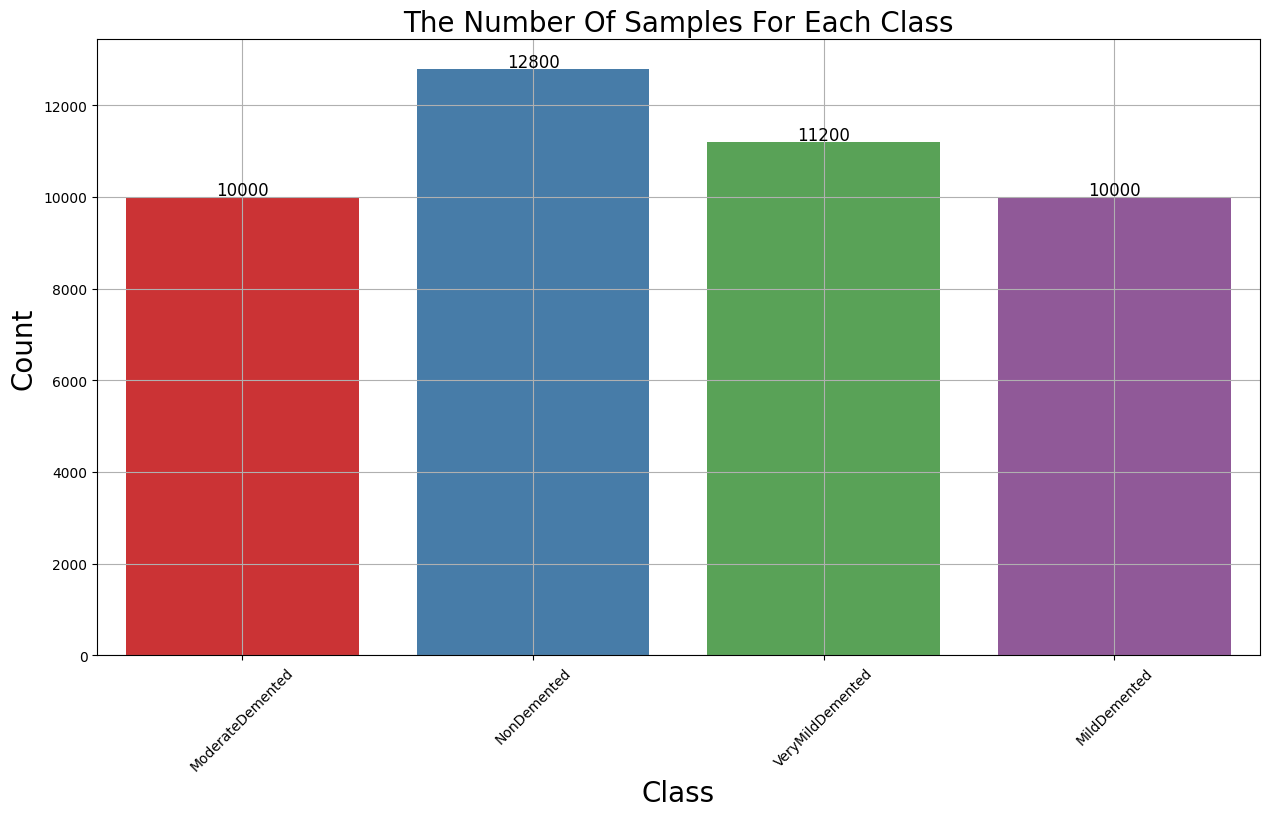

In [4]:
# Assuming `df` is your DataFrame and `label` is the column with class labels
class_counts = df['label'].value_counts()

# Print exact counts
print("Exact counts for each class:")
print(class_counts)

# Plot the class distribution
plt.figure(figsize=(15, 8))
ax = sns.countplot(x=df['label'], palette='Set1')
ax.set_xlabel("Class", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
plt.title('The Number Of Samples For Each Class', fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)

# Annotate each bar with the exact count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

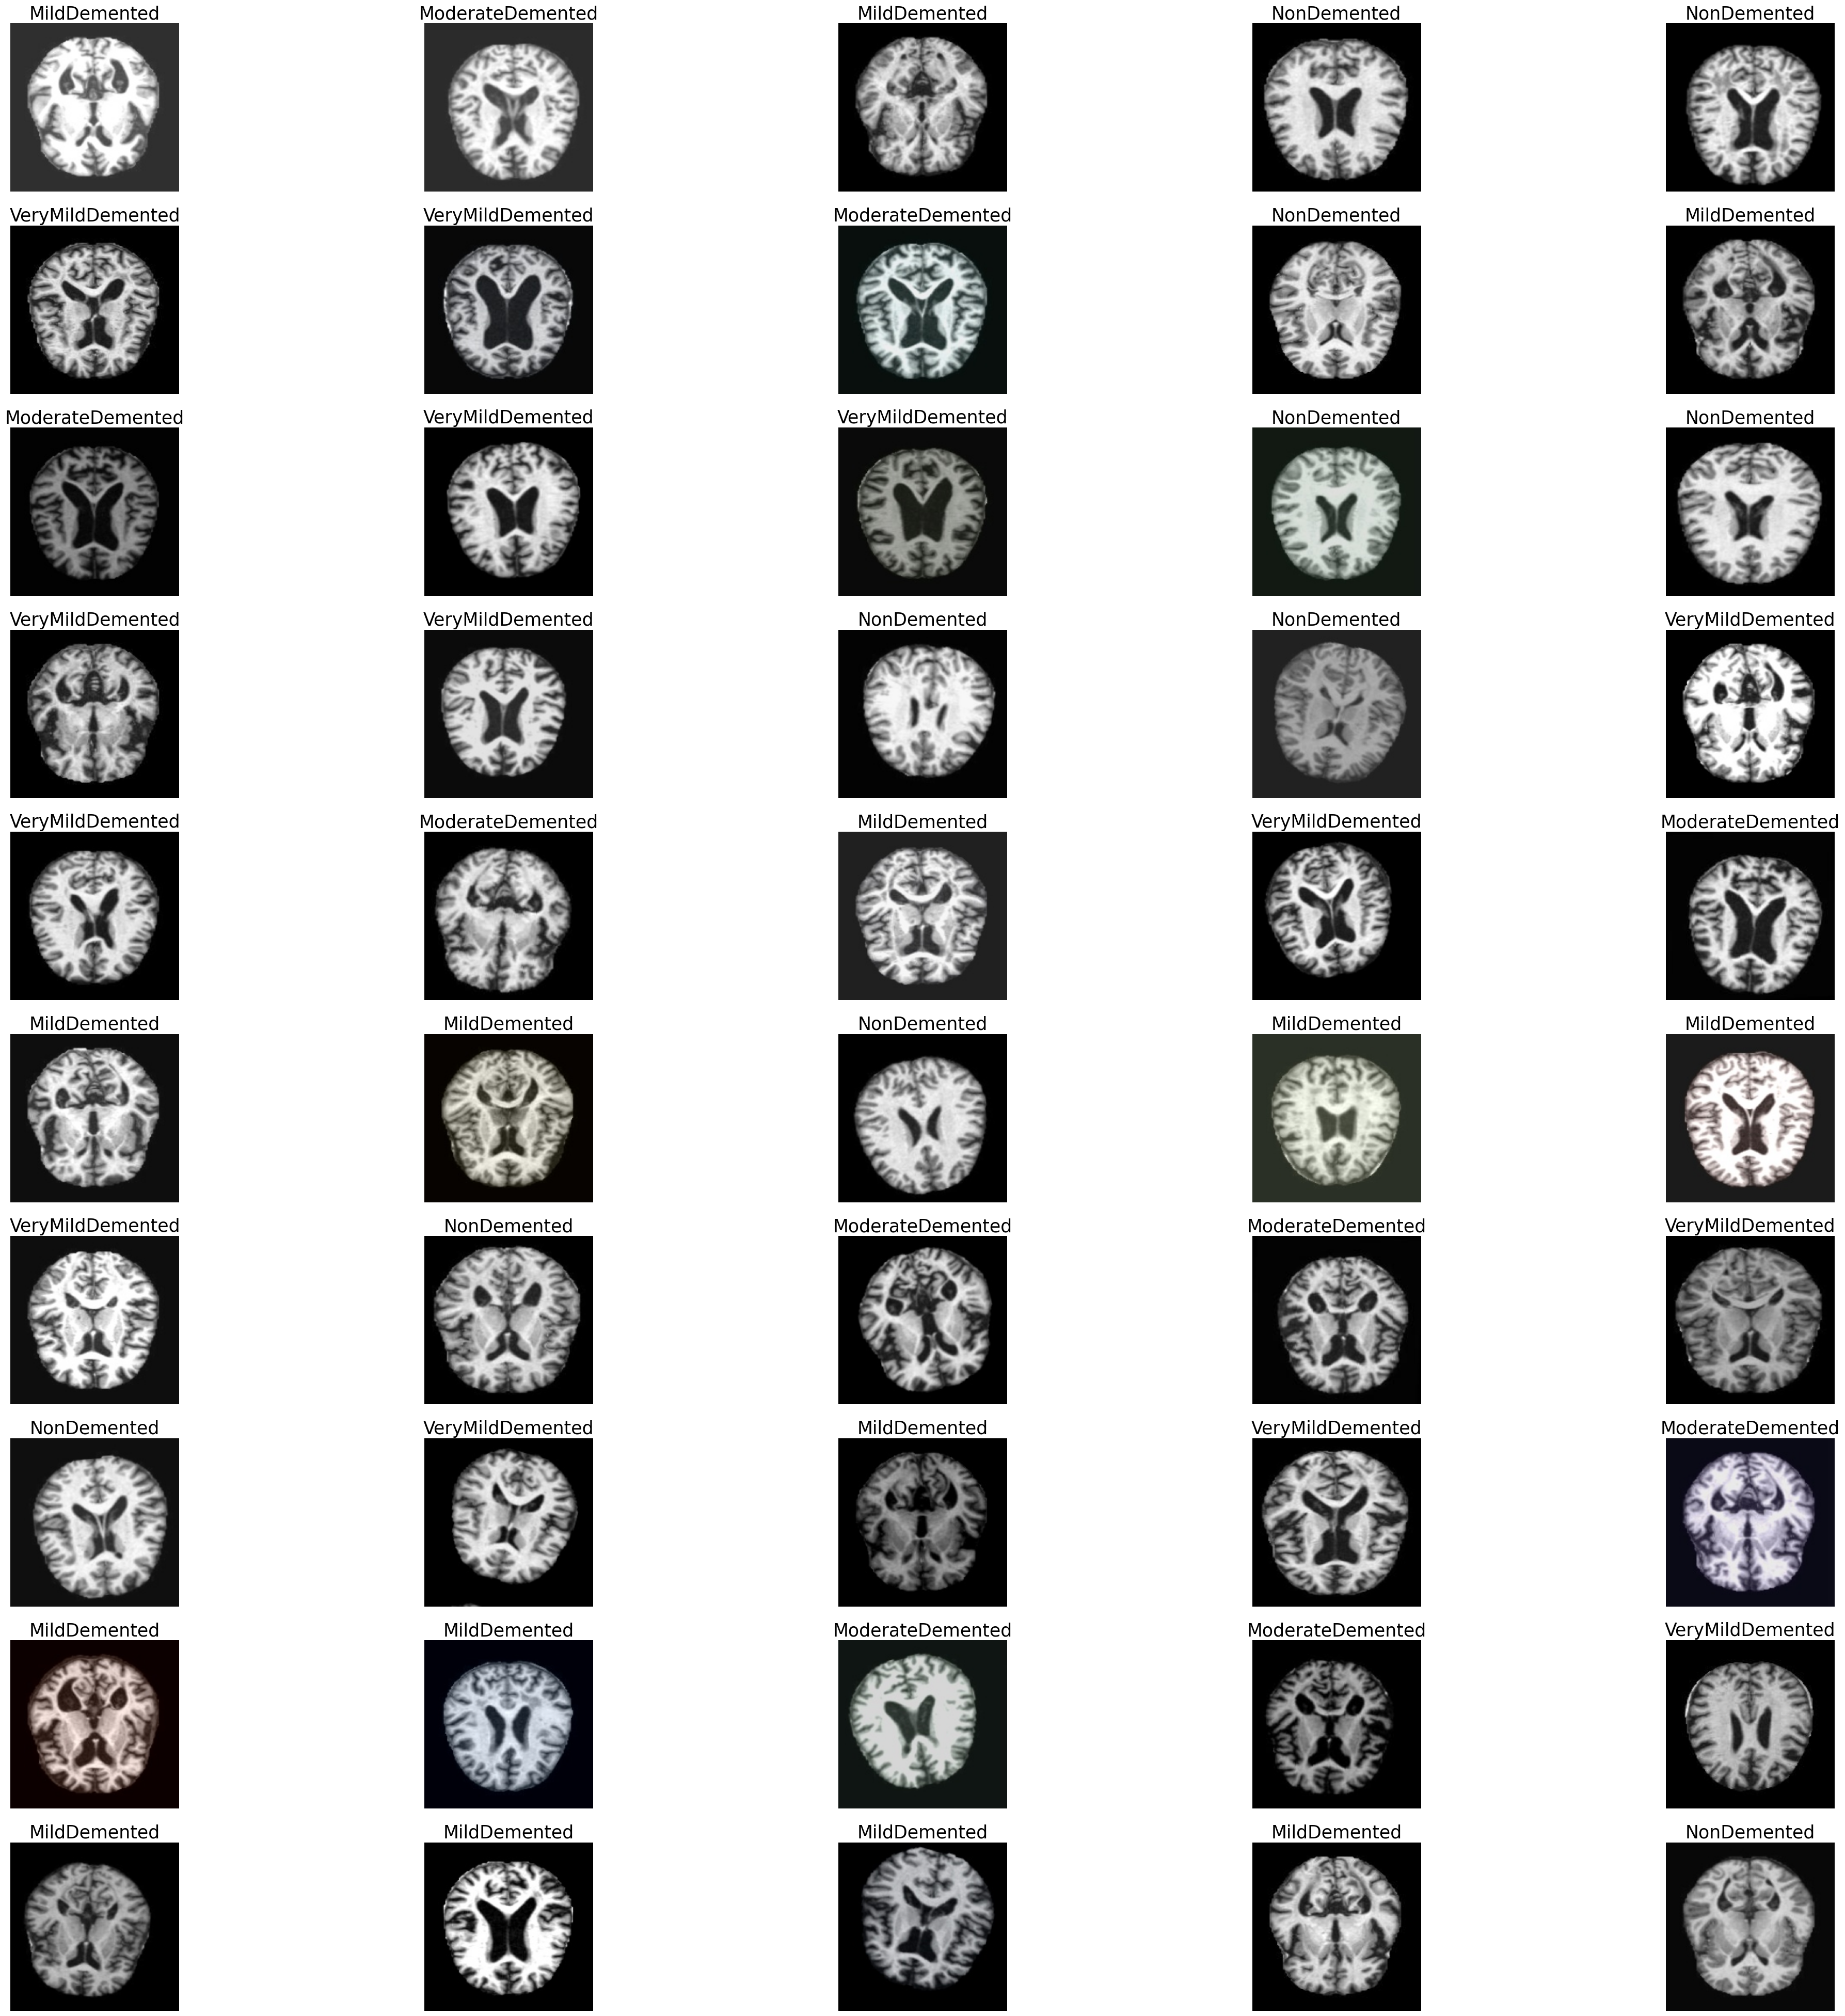

In [5]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

In [15]:
X_data, _, y_data, _ = train_test_split(df['image'], df['label'], test_size=0.9, random_state=42, shuffle=True, stratify=df['label'])

print(X_data.shape)
print(y_data.shape)

(4400,)
(4400,)


In [16]:
print(X_train.shape)
#, X_test1, y_train, y_test1, X_val, X_test, y_val, y_test

(7040,)


In [17]:
X_train, X_test1, y_train, y_test1 = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42,shuffle=True, stratify = y_data)

X_val, X_test, y_val, y_test = train_test_split(
    X_test1, y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)

df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

In [18]:
image_size = (224,224)
batch_size = 32
datagen = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.resnet.preprocess_input,
    rescale=1./255,
    horizontal_flip=True
)
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 3520 validated image filenames belonging to 4 classes.
Found 440 validated image filenames belonging to 4 classes.
Found 440 validated image filenames belonging to 4 classes.


In [19]:
class_num=list(train_generator.class_indices.keys())
class_num

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [20]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential()
model.add(tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, pooling='avg', weights='imagenet'))
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2048, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(4, activation='softmax'))
model.layers[0].trainable = False

# Build the model with the correct input shape
model.build(input_shape=(None, 224, 224, 3))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,881,924 (68.21 MB)

 Trainable params: 3,160,068 (12.05 MB)

 Non-trainable params: 14,721,856 (56.16 MB)

In [ ]:
checkpoint_cb = ModelCheckpoint("model_VGG16.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=10, restore_best_weights=True)
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
106/110 ━━━━━━━━━━━━━━━━━━━━ 1:14 19s/step - accuracy: 0.5609 - loss: 1.9512

I have a bad feeling, that 40 min it is only one epoch of 50 ))

In [ ]:
model.save('/content/model_VGG16.keras')
model.export('/content/model_VGG16')

In [ ]:
import os
print(os.listdir('/content'))

In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [ ]:
score, acc= model.evaluate(test_generator)
print('Val Loss =', score)
print('Val Accuracy =', acc)

In [ ]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

In [ ]:
plt.figure(figsize=(30,70))
batch = next(test_generator)
images= batch[0]
for n in range(32):
    plt.subplot(8,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(f"Actual: {class_num[y_test[n]]}, \n Predicted: {class_num[y_pred[n]]}.\n Confidence: {round(predictions[n][np.argmax(predictions[n])],0)}%",fontsize=20)

In [ ]:
CM = confusion_matrix(y_test,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues',xticklabels=class_num, yticklabels=class_num)
CM

In [ ]:
ClassificationReport = classification_report(y_test,y_pred,target_names=class_num)
print('Classification Report is : ', ClassificationReport)

In [ ]:
class_num=list(train_generator.class_indices.keys())
class_num

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

def predict_single_image(model, image_path, class_num, target_size=(224, 224)):
    """
    Predicts the class of a single image and displays it with the prediction and confidence.

    Args:
        model: Trained Keras model.
        image_path (str): Path to the image file.
        class_num (dict): Dictionary mapping class indices to class labels.
        target_size (tuple): Target size for resizing the image.
    """
    # Load and preprocess the image
    image = load_img(image_path, target_size=target_size)
    image_array = img_to_array(image)  # Convert to numpy array
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    image_array = image_array / 255.0  # Normalize

    # Predict
    predictions = model.predict(image_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class_label = class_num[predicted_class_index]
    confidence = round(np.max(predictions) * 100, 2)

    # Display the image and prediction
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class_label}\nConfidence: {confidence}%", fontsize=16)
    plt.show()

# Example Usage
image_path = "/kaggle/input/alzheimers-multiclass-dataset-equal-and-augmented/combined_images/VeryMildDemented/0073c8fe-469d-4160-9344-37d61ac6f9bd.jpg"
class_num = {0: 'MildDemented', 1: 'ModerateDemented', 2: 'NonDemented', 3: 'VeryMildDemented'}
predict_single_image(model, image_path, class_num)
